In [1]:
!pip install opendatasets --quiet

import opendatasets as od

od.download('https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mayura2000
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification


100%|██████████| 155M/155M [00:00<00:00, 1.06GB/s]

In [2]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
device

'cpu'

https://docs.pytorch.org/vision/stable/models

In [5]:
train_df = pd.read_csv("/content/bean-leaf-lesions-classification/train.csv")
val_df = pd.read_csv("/content/bean-leaf-lesions-classification/val.csv")

train_df.head()

,image:FILE,category
0,train/healthy/healthy_train.98.jpg,0
1,train/healthy/healthy_train.148.jpg,0
2,train/healthy/healthy_train.306.jpg,0
3,train/healthy/healthy_train.305.jpg,0
4,train/healthy/healthy_train.40.jpg,0


In [23]:
train_df["image:FILE"] = "/content/bean-leaf-lesions-classification/" + train_df["image:FILE"]
val_df["image:FILE"] = "/content/bean-leaf-lesions-classification/" + val_df["image:FILE"]

In [24]:
train_df.category.unique()

array([0, 1, 2])

In [25]:
train_df.category.value_counts()

,count
category,
2,348
1,345
0,341


In [26]:
print(train_df.shape, val_df.shape)

(1034, 2) (133, 2)


In [27]:
val_df.category.value_counts()

,count
category,
2,45
0,44
1,44


In [28]:
transform = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float)
    ]
)

In [29]:
class CustomImageDataset(Dataset):
  def __init__(self, dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform
    self.label = torch.tensor(dataframe['category']).to(device)

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, index):
    img_path = self.dataframe.iloc[index, 0]
    label = self.label[index]
    image = Image.open(img_path)

    if self.transform:
      image = (self.transform(image) / 255.0).to(device)

    return image, label

In [30]:
train_dataset = CustomImageDataset(dataframe=train_df, transform=transform)
val_dataset = CustomImageDataset(dataframe=val_df, transform=transform)

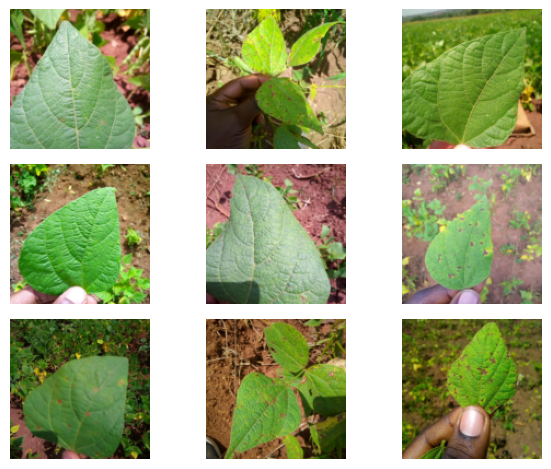

In [40]:
n_rows = 3
n_cols = 3

f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
  for col in range(n_cols):
    image = train_dataset[np.random.randint(0, train_dataset.__len__())][0].cpu()
    axarr[row, col].imshow((image*255.0).squeeze().permute(1, 2, 0))
    axarr[row, col].axis('off')

plt.tight_layout()
plt.show()

In [41]:
LR = 1e-3
BATCH_SIZE = 4
EPOCHS = 15

In [42]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [44]:
from torchvision import models
googlenet_model = models.googlenet(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 149MB/s]


In [45]:
for param in googlenet_model.parameters():
  param.requires_grad = True

In [46]:
googlenet_model.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [47]:
num_classes = len(train_df['category'].unique())

In [48]:
num_classes

3

In [49]:
googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model.fc

Linear(in_features=1024, out_features=3, bias=True)

In [ ]:
for param in googlenet_model.parameters():
  param.requires_grad = False

In [50]:
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [51]:
loss_func = nn.CrossEntropyLoss()
optimizer = Adam(googlenet_model.parameters(), lr=LR)

In [52]:
total_loss_train_plot = []
total_acc_train_plot = []

In [53]:
for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = googlenet_model(inputs)
    train_loss = loss_func(outputs, labels)

    total_loss_train += train_loss.item()

    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__() * 100, 4))
  print(
      f"""Epoch {epoch+1}/{EPOCHS}
      Train Loss: {round(total_loss_train/1000, 4)} Train Accuracy: {round(total_acc_train/train_dataset.__len__() * 100, 4)}%
      """
  )

Epoch 1/15
      Train Loss: 0.2439 Train Accuracy: 55.8027%
      
Epoch 2/15
      Train Loss: 0.2164 Train Accuracy: 61.7988%
      
Epoch 3/15
      Train Loss: 0.1947 Train Accuracy: 66.1509%
      
Epoch 4/15
      Train Loss: 0.1705 Train Accuracy: 73.1141%
      
Epoch 5/15
      Train Loss: 0.1731 Train Accuracy: 70.3095%
      
Epoch 6/15
      Train Loss: 0.1671 Train Accuracy: 74.1779%
      
Epoch 7/15
      Train Loss: 0.1662 Train Accuracy: 74.1779%
      
Epoch 8/15
      Train Loss: 0.1518 Train Accuracy: 76.6925%
      
Epoch 9/15
      Train Loss: 0.1376 Train Accuracy: 78.8201%
      
Epoch 10/15
      Train Loss: 0.1284 Train Accuracy: 81.1412%
      
Epoch 11/15
      Train Loss: 0.1016 Train Accuracy: 85.1064%
      
Epoch 12/15
      Train Loss: 0.1182 Train Accuracy: 82.882%
      
Epoch 13/15
      Train Loss: 0.0988 Train Accuracy: 84.8162%
      
Epoch 14/15
      Train Loss: 0.0794 Train Accuracy: 89.4584%
      
Epoch 15/15
      Train Loss: 0.0993 Train A

In [54]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

  for inputs, labels in val_loader:
    prediction = googlenet_model(inputs)

    acc = (torch.argmax(prediction, axis=1) == labels).sum().item()

    total_acc_test += acc

In [55]:
print(round(total_acc_test/val_dataset.__len__() * 100, 2))

89.47


### Transfer Learning

In [57]:
googlenet_model = models.googlenet(weights='DEFAULT')

for param in googlenet_model.parameters():
  param.requires_grad = False


googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model.fc.requires_grad = True

googlenet_model.to(device)

for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = googlenet_model(inputs)
    train_loss = loss_func(outputs, labels)

    total_loss_train += train_loss.item()

    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__() * 100, 4))
  print(
      f"""Epoch {epoch+1}/{EPOCHS}
      Train Loss: {round(total_loss_train/1000, 4)} Train Accuracy: {round(total_acc_train/train_dataset.__len__() * 100, 4)}%
      """
  )

Epoch 1/15
      Train Loss: 0.2919 Train Accuracy: 32.9787%
      
Epoch 2/15
      Train Loss: 0.2919 Train Accuracy: 34.236%
      
Epoch 3/15
      Train Loss: 0.2912 Train Accuracy: 33.1721%
      
Epoch 4/15
      Train Loss: 0.2935 Train Accuracy: 32.3985%
      
Epoch 5/15
      Train Loss: 0.2935 Train Accuracy: 33.2689%
      
Epoch 6/15
      Train Loss: 0.2916 Train Accuracy: 32.882%
      
Epoch 7/15
      Train Loss: 0.2897 Train Accuracy: 35.0097%
      
Epoch 8/15
      Train Loss: 0.2916 Train Accuracy: 34.7195%
      
Epoch 9/15
      Train Loss: 0.2902 Train Accuracy: 34.1393%
      
Epoch 10/15
      Train Loss: 0.2922 Train Accuracy: 32.6886%
      
Epoch 11/15
      Train Loss: 0.292 Train Accuracy: 33.6557%
      
Epoch 12/15
      Train Loss: 0.291 Train Accuracy: 34.4294%
      
Epoch 13/15
      Train Loss: 0.2941 Train Accuracy: 33.3656%
      
Epoch 14/15
      Train Loss: 0.2926 Train Accuracy: 33.2689%
      
Epoch 15/15
      Train Loss: 0.2911 Train Accu

In [58]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

  for inputs, labels in val_loader:
    prediction = googlenet_model(inputs)

    acc = (torch.argmax(prediction, axis=1) == labels).sum().item()

    total_acc_test += acc

In [59]:
print(round(total_acc_test/val_dataset.__len__() * 100, 2))

32.33
